# Building the Classifier

This notebook is made to evaluate classifier performance by **splitting the available annotated "training" data of the challenge into train in test splits** and trying different classification methods.

In [1]:
import pickle
import pandas as pd
import numpy as np
from os.path import join
import json
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

import vis
import utils

In [2]:
sets = [('colombia', 'borde_rural'),
        ('colombia', 'borde_soacha'),
        ('guatemala', 'mixco_1_and_ebenezer'), 
        ('guatemala', 'mixco_3'),
        ('st_lucia', 'dennery')]

## 0. Set parameters

In [3]:
#HEIGHT, WIDTH, CHANNELS = 224, 224, 3
HEIGHT, WIDTH, CHANNELS = 128, 128, 3
POOLING_METHOD = 'avg'
MODEL_NAME = 'mobilenet'

In [15]:
feature_path = join('..', '..', 'features')
data_path = join('..', '..', 'stac')

## 1. Prepare training and test data

### 1.1 Load labels and training features from all region sets in `sets`.

In [16]:
features = utils.get_features(sets, feature_path, MODEL_NAME, HEIGHT, POOLING_METHOD)
labels_dict = utils.get_labels(sets, data_path)            
labels = np.array(list(labels_dict.values()))

Classes in the data set are pretty unbalanced, which should be kept in mind when assessing classification performance:

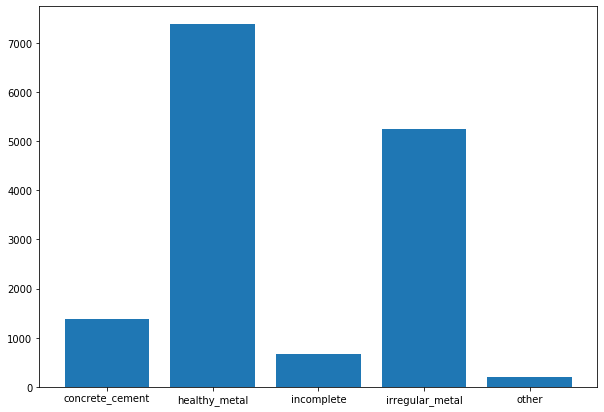

In [11]:
materials = {'concrete_cement':0, 'healthy_metal':1, 'incomplete':2, 'irregular_metal':3, 'other':4}

plt.figure(figsize=(10, 7))
plt.bar(range(5), np.bincount(utils.labels_int(labels)))
plt.xticks(ticks=range(5), labels=list(materials.keys()))
plt.show()


## 2. Scale the features 

In [16]:
scaler = StandardScaler()
scaler.fit(features)
features_scaled = scaler.transform(features)

In [17]:
print(features.shape)
print(labels.shape)

(14852, 1024)
(14852,)


In [18]:
pca = PCA()
pca.fit(features_scaled)

PCA()

In [19]:
top_x = 250
top_pc = pca.components_[:top_x]
features_proj = np.matmul(np.matmul(top_pc.T, top_pc), features_scaled.T).T

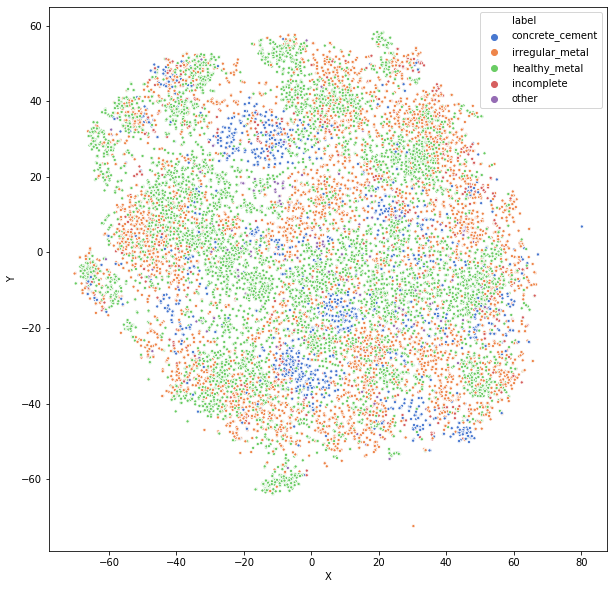

In [20]:
vis.plot_tsne(features_proj, labels, marker_size=10)

### Split into training and test set

In [72]:
features_train, features_test, labels_train, labels_test = train_test_split(features,
                                                                            labels,
                                                                            test_size=0.33,
                                                                            random_state=42)

## Random Forest Classifiation

In [18]:
forest = RandomForestClassifier(n_estimators=500, max_depth=16, random_state=0, n_jobs=6)
forest.fit(features_train, labels_train) 

RandomForestClassifier(max_depth=16, n_estimators=500, n_jobs=6, random_state=0)

Evaluate performance

In [19]:
pred_probas = forest.predict_proba(features_test)
log_l = log_loss(labels_test, pred_probas)
log_l

0.7761277363348201

In [20]:
cv_results = cross_validate(forest, feature_matrix_global, labels_global,
                            cv=5, scoring=('f1_macro', 'accuracy', 'balanced_accuracy'),
                            n_jobs=6)

NameError: name 'feature_matrix_global' is not defined

In [ ]:
avg_f1_macro = np.mean(cv_results['test_f1_macro'])
avg_accuracy = np.mean(cv_results['test_accuracy'])
print("Average F1 macro: ", avg_f1_macro)
print("Average Accuracy: ", avg_accuracy)

In [21]:
materials = {'concrete_cement':0, 'healthy_metal':1, 'incomplete':2, 'irregular_metal':3, 'other':4}
predicted_labels = forest.predict(features_test)
cm = confusion_matrix(labels_test, predicted_labels)

row_sums = cm.sum(axis=1, keepdims=True)
cm_norm = cm / row_sums

In [22]:
cm

array([[ 198,   96,    0,  139,    0],
       [  10, 1779,    0,  328,    0],
       [  20,   28,    0,  188,    0],
       [   5,  413,    0, 1315,    0],
       [   2,   24,    0,   25,    0]])

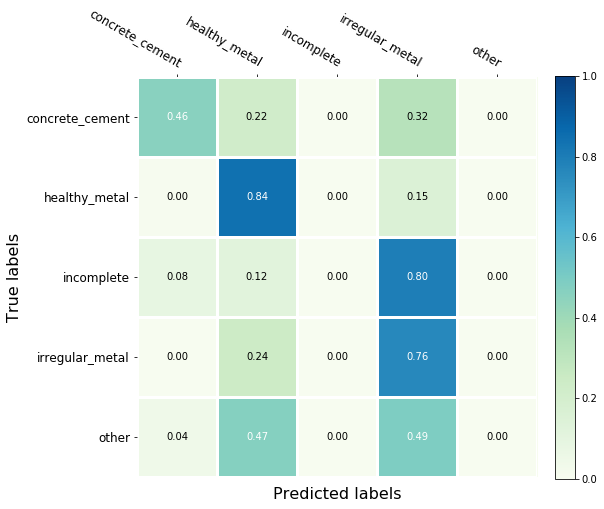

In [24]:
import matplotlib.pyplot as plt
import utils

fig, ax = plt.subplots(figsize=(8.5, 8.5))
im, cbar = utils.heatmap(cm_norm,  materials.keys(), materials.keys(), ax=ax,
                   cmap="GnBu")
texts = utils.annotate_heatmap(im)

fig.tight_layout()
plt.show()

fname = join('..', 'documentation', 'figures', 'results', 'nn_based_cm_rf.png')
fig.savefig(fname)

## Support Vector Machine Classification

(Optional): Use the top-x features of the Random Forest model for SVM training. Thereby reduce training time while compromising accuracy only very little.

In [45]:
top_x = 500

importances = forest.feature_importances_
indices = np.argsort(importances)[:top_x]

features_selected = features_scaled[:, indices]

In [46]:
features_selected.shape

(13848, 100)

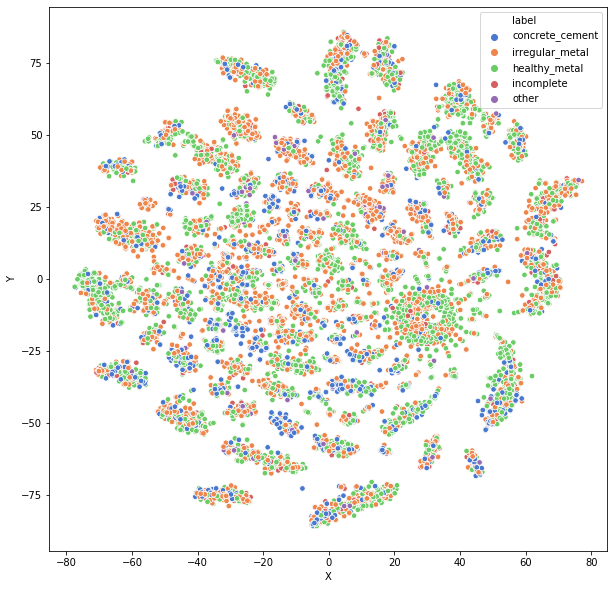

In [47]:
vis.plot_tsne(features_selected, labels)

When splitting into training and test set, choose `feature_matrix_global` for full features or `feature_matrix_selected`for the top x features from RF.

Train the classifier

In [75]:
clf = svm.SVC(gamma='scale', probability=True, C=100, decision_function_shape='ovr')
clf.fit(features_train, labels_train)

SVC(C=100, probability=True)

Visualize results in confusion matrix

In [76]:
materials = {'concrete_cement':0, 'healthy_metal':1, 'incomplete':2, 'irregular_metal':3, 'other':4}
predicted_labels = clf.predict(features_test)
cm = confusion_matrix(labels_test, predicted_labels)

row_sums = cm.sum(axis=1, keepdims=True)
cm_norm = cm / row_sums

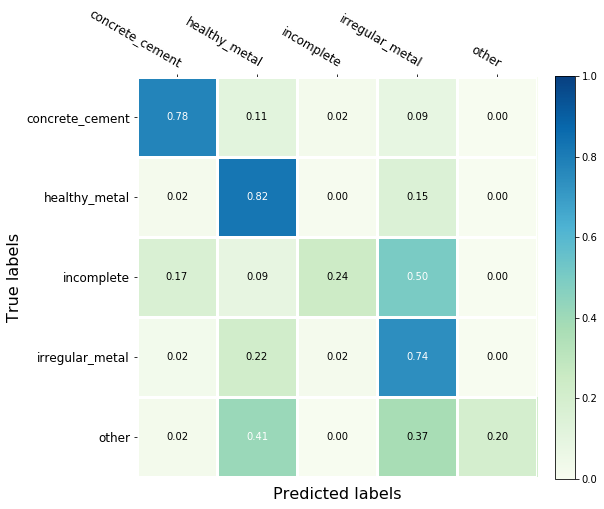

In [77]:
import matplotlib.pyplot as plt
import utils

fig, ax = plt.subplots(figsize=(8.5, 8.5))
im, cbar = utils.heatmap(cm_norm,  materials.keys(), materials.keys(), ax=ax,
                   cmap="GnBu")
texts = utils.annotate_heatmap(im)

fig.tight_layout()
plt.show()

fname = join('..', 'documentation', 'figures', 'results', 'nn_based_cm_svm.png')
fig.savefig(fname)

Evaluate performance in terms of log loss and other scores

In [ ]:
pred_probas = clf.predict_proba(features_test)
log_l = log_loss(labels_test, pred_probas)
log_l

In [ ]:
cv_results = cross_validate(clf, feature_matrix_selected, labels_global,
                            cv=5, scoring=('f1_macro', 'f1_micro', 'accuracy', 'balanced_accuracy'),
                            n_jobs=7)

In [ ]:
cv_results

In [ ]:
avg_accuracy = np.mean([0.76009421, 0.7512622 , 0.76203299, 0.77265072, 0.75682048])
avg_f1_macro = np.mean([0.62294524, 0.63484941, 0.64512324, 0.6325258 , 0.61330979])

In [ ]:
print(avg_accuracy, avg_f1_macro)

## Evaluate Performance of RF classifier